In [1]:

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import QuantLib as ql
%matplotlib inline



In [2]:
import warnings


warnings.simplefilter("ignore")

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [4]:
# 
real_ytm_df = pd.read_csv('./data/CN_Real_Yield.csv')
real_ytm_df['Date'] = pd.to_datetime(real_ytm_df['Date'])
real_ytm_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2012-01-04,2.6380,2.6754,2.8199,2.8668,2.9462,3.0255,3.1812,3.3368,3.3695,3.4023,3.4350,3.8059,3.9458,4.0607
1,2012-01-05,2.6279,2.6750,2.8066,2.8984,2.9796,3.0608,3.2045,3.3482,3.3771,3.4061,3.4350,3.8038,3.9441,4.0509
2,2012-01-06,2.6404,2.6767,2.8140,2.8913,2.9948,3.0983,3.2176,3.3369,3.3679,3.3990,3.4300,3.8027,3.9430,4.0498
3,2012-01-09,2.6409,2.6772,2.8090,2.8925,2.9973,3.1022,3.2123,3.3224,3.3466,3.3708,3.3950,3.7470,3.8873,4.0488
4,2012-01-10,2.5919,2.6809,2.8318,2.9089,3.0060,3.1032,3.2152,3.3272,3.3648,3.4024,3.4400,3.8006,3.8878,4.0622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739,2022-12-26,2.1778,2.2398,2.3669,2.4616,2.5396,2.6175,2.7175,2.8175,2.8249,2.8324,2.8398,2.9777,3.0579,3.2225
2740,2022-12-27,2.2125,2.2615,2.3889,2.4898,2.5777,2.6656,2.7526,2.8395,2.8475,2.8556,2.8636,3.0014,3.0676,3.2182
2741,2022-12-28,2.2398,2.2732,2.4056,2.4746,2.5771,2.6795,2.7595,2.8395,2.8496,2.8598,2.8699,3.0078,3.0679,3.2125
2742,2022-12-29,2.1737,2.1952,2.3605,2.4405,2.5415,2.6425,2.7314,2.8202,2.8255,2.8309,2.8362,2.9741,3.0459,3.2021


In [5]:
model_ytm_df = pd.read_csv('./data/CN_AFNS_Model_Yield.csv')
model_ytm_df['Date'] = pd.to_datetime(model_ytm_df['Date'])
model_ytm_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2012-01-04,2.212276,2.366311,2.621428,2.820993,2.978523,3.103775,3.203875,3.284102,3.348428,3.399889,3.440841,3.541446,3.546294,3.427012
1,2012-01-05,2.264182,2.409486,2.651280,2.842237,2.995044,3.118751,3.219889,3.303236,3.372342,3.429889,3.477936,3.621839,3.671854,3.626652
2,2012-01-06,2.313283,2.451063,2.680727,2.862897,3.009693,3.129686,3.228999,3.312067,3.382149,3.441679,3.492513,3.657229,3.731471,3.728014
3,2012-01-09,2.345565,2.477170,2.696694,2.871271,3.012598,3.128887,3.225955,3.307978,3.377995,3.438259,3.490466,3.667738,3.757834,3.782582
4,2012-01-10,2.375297,2.502419,2.714585,2.883650,3.021004,3.134598,3.230029,3.311286,3.381248,3.442034,3.495228,3.681563,3.783120,3.828268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739,2022-12-26,2.053561,2.156342,2.324679,2.455668,2.559933,2.644763,2.715180,2.774676,2.825699,2.869995,2.908823,3.046588,3.123292,3.148300
2740,2022-12-27,2.090931,2.192052,2.357343,2.485615,2.587453,2.670111,2.738582,2.796331,2.845785,2.888668,2.926222,3.059214,3.132924,3.154602
2741,2022-12-28,2.101724,2.202486,2.367106,2.494762,2.596036,2.678176,2.746172,2.803484,2.852535,2.895046,2.932258,3.063888,3.136654,3.157170
2742,2022-12-29,2.068063,2.170355,2.337783,2.467944,2.571454,2.655596,2.725384,2.784304,2.834800,2.878612,2.916996,3.053013,3.128531,3.152098


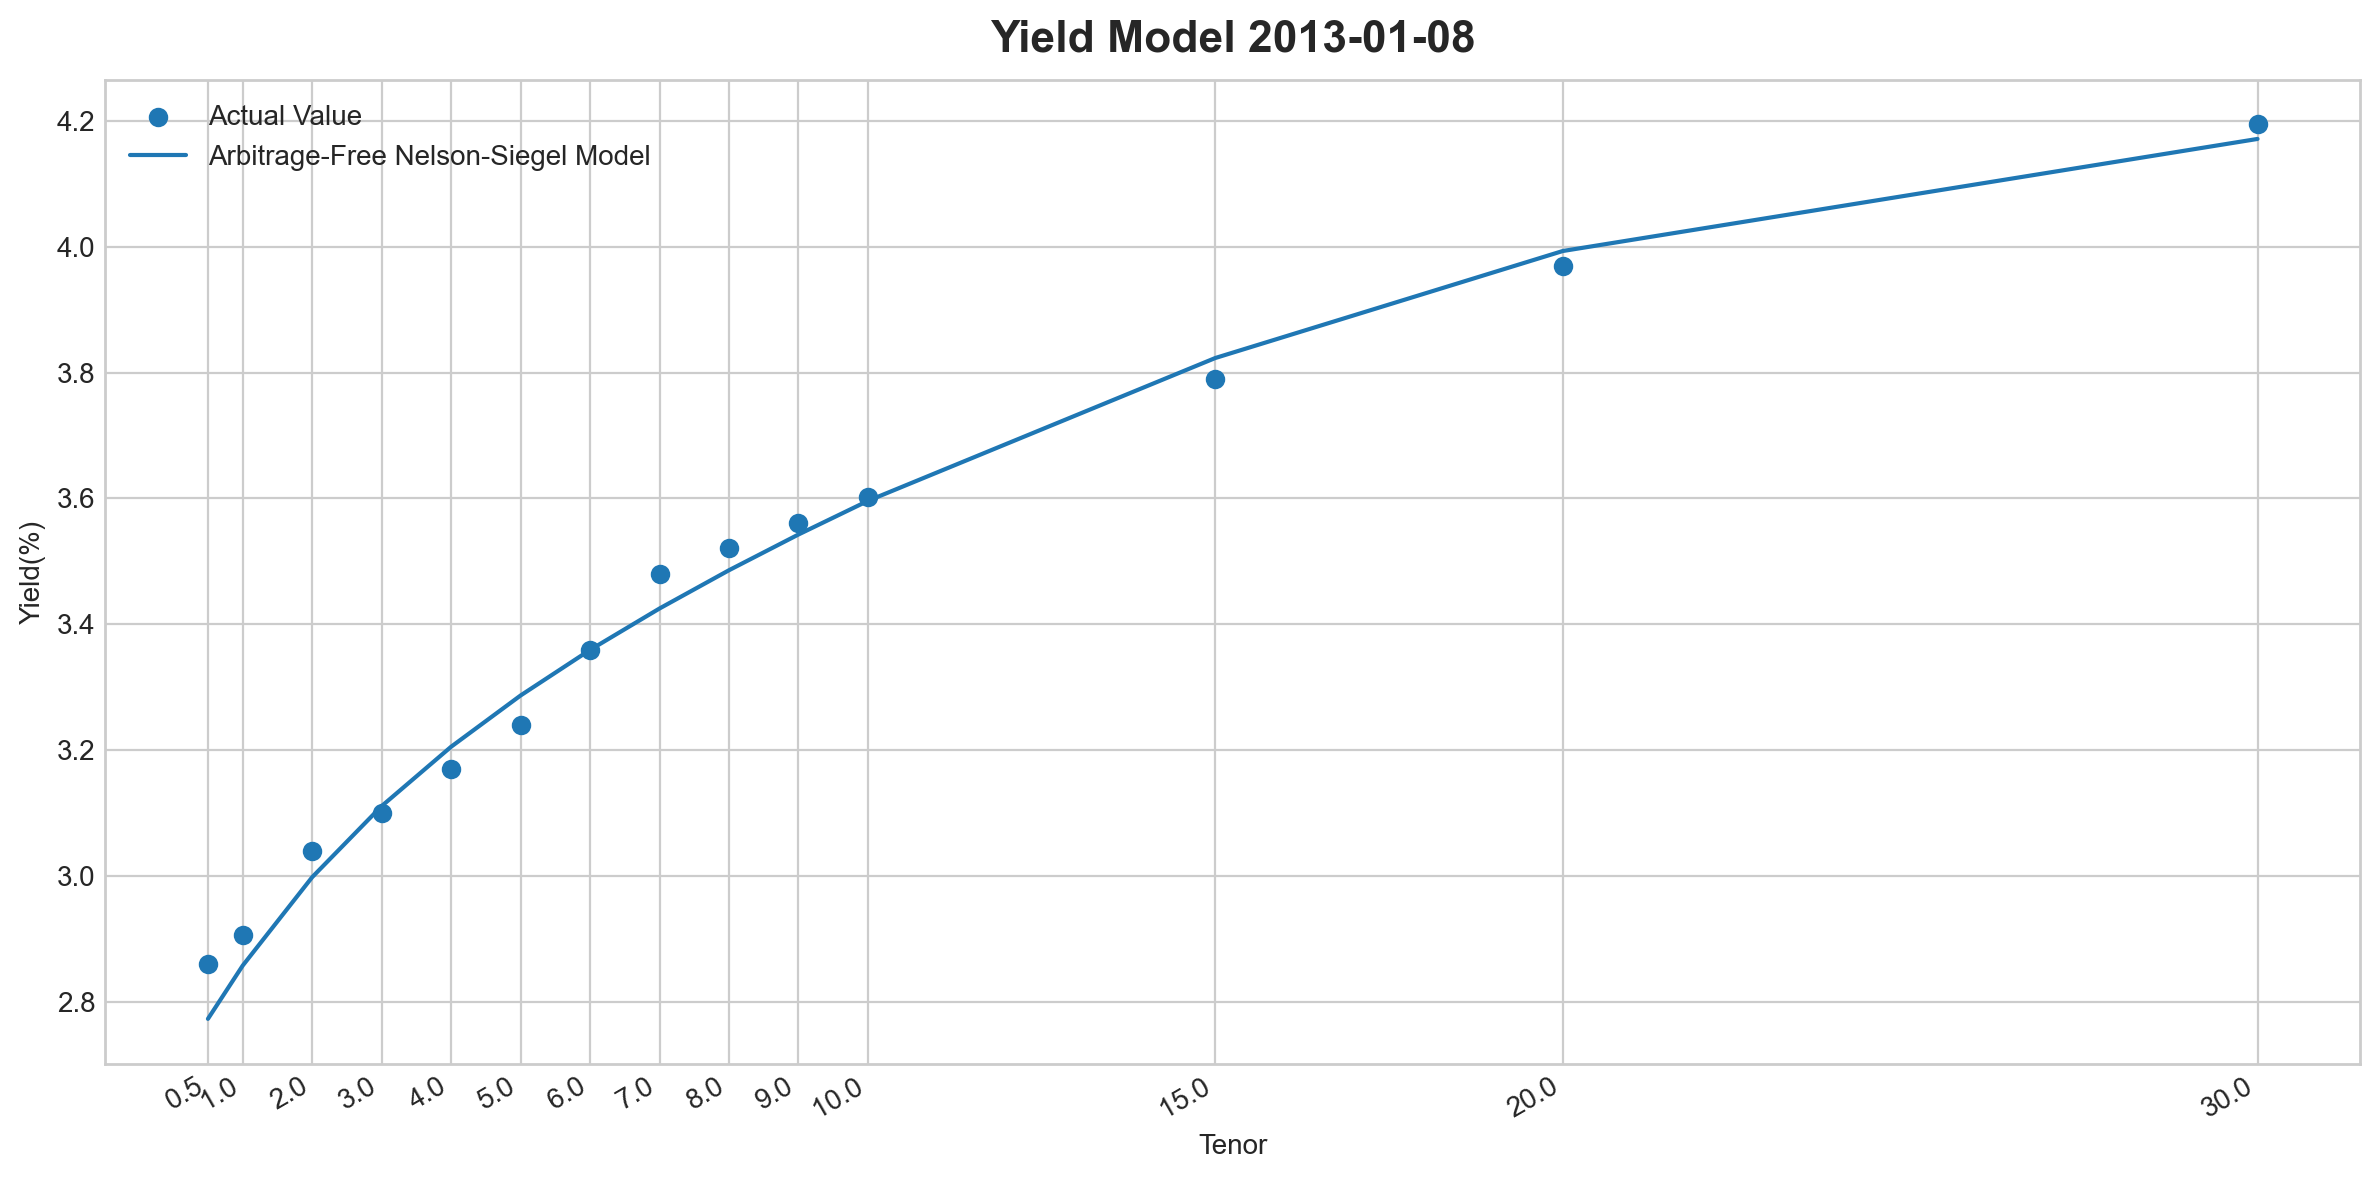

In [6]:
# 选择某一天
test_date_str = "2013-01-08"
test_date =  datetime.datetime.strptime(test_date_str, "%Y-%m-%d")

fig, ax = plt.subplots(figsize=(12, 6))
time_list = [0.50, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
tenor_list = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', 
              '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']

temp_actual_ytm_df = real_ytm_df[real_ytm_df['Date']==test_date][tenor_list]
temp_actual_ytm_list = temp_actual_ytm_df.values[0]



temp_bootstrap_ytm_df = model_ytm_df[model_ytm_df['Date']==test_date][tenor_list]
temp_bootstrap_ytm_list = temp_bootstrap_ytm_df.values[0]


ax.scatter(time_list, temp_actual_ytm_list, label="Actual Value")
ax.plot(time_list, temp_bootstrap_ytm_list, label="Arbitrage-Free Nelson-Siegel Model")


plt.xticks(time_list)


ax.set_title("Yield Model " + test_date_str)
ax.set_xlabel("Tenor")
ax.set_ylabel("Yield(%)")
fig.autofmt_xdate()
plt.tight_layout()
plt.legend(loc=2)

In [7]:
factor_df = pd.read_csv('./data/CN_AFNS_Factor.csv')
factor_df['Date'] = pd.to_datetime(factor_df['Date'])
factor_df

,Date,Level,Slope,Curvature
0,2012-01-04,6.219551,-4.192263,0.995183
1,2012-01-05,6.645468,-4.556778,0.323284
2,2012-01-06,6.878650,-4.732623,-0.106840
3,2012-01-09,7.024093,-4.839006,-0.419104
4,2012-01-10,7.135533,-4.915797,-0.645238
...,...,...,...,...
2739,2022-12-26,6.438232,-4.513261,-0.991240
2740,2022-12-27,6.437766,-4.473574,-1.001645
2741,2022-12-28,6.437606,-4.462218,-1.000916
2742,2022-12-29,6.438723,-4.498705,-0.991197


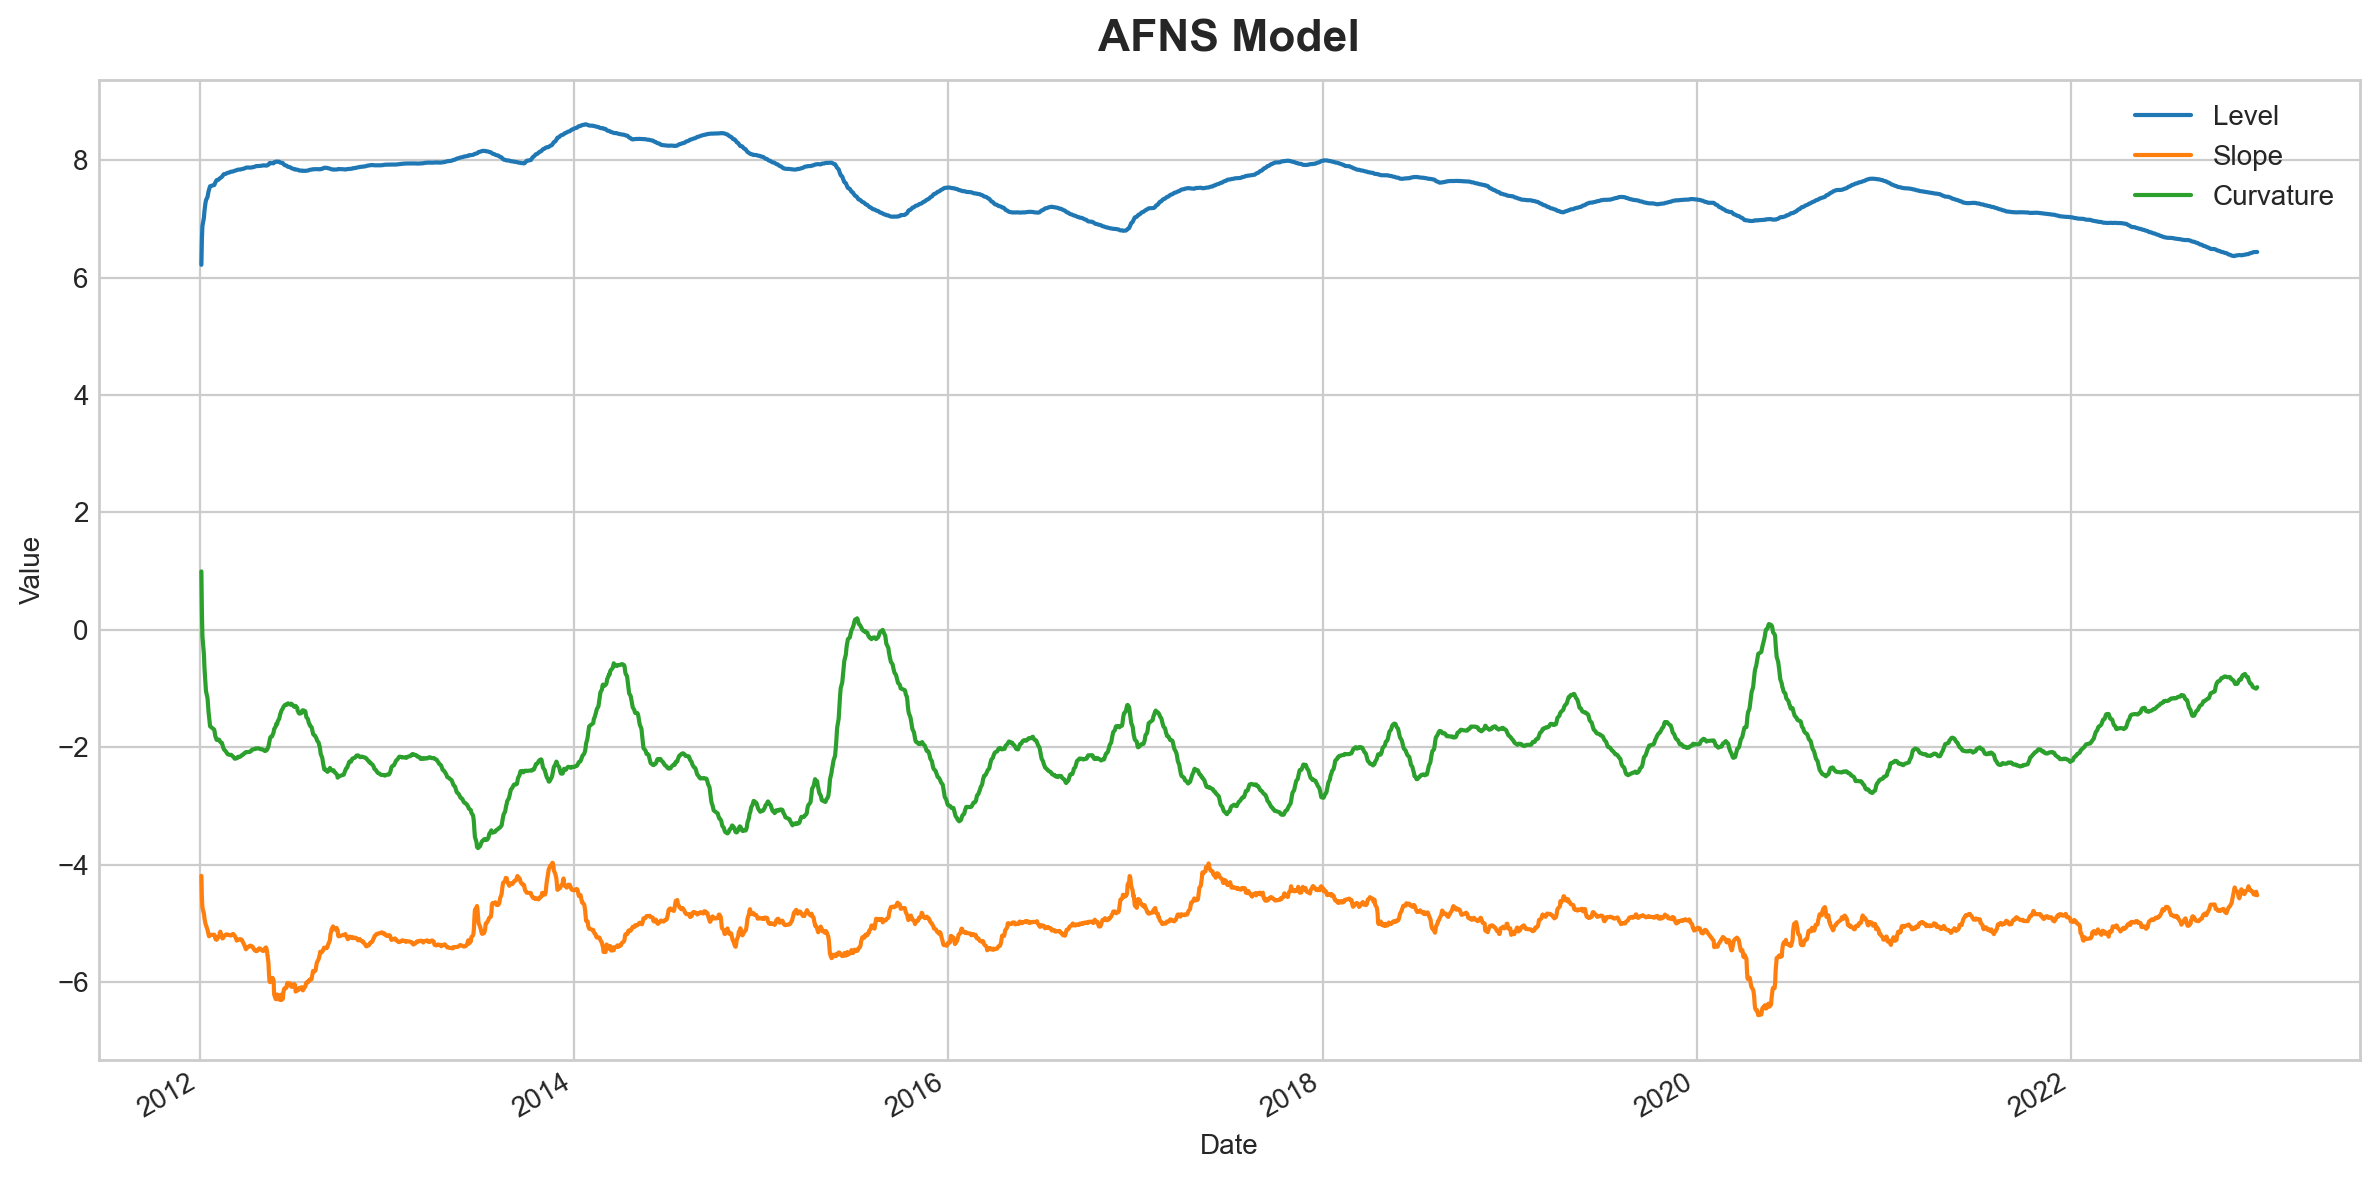

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(factor_df['Date'], factor_df['Level'], label="Level")
ax.plot(factor_df['Date'], factor_df['Slope'], label="Slope")
ax.plot(factor_df['Date'], factor_df['Curvature'], label="Curvature")
#ax.plot(curve_df['Date'], curve_df['Tau'], label="Tau")

ax.set_title("AFNS Model")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
fig.autofmt_xdate()
plt.tight_layout()
plt.legend(loc=1)

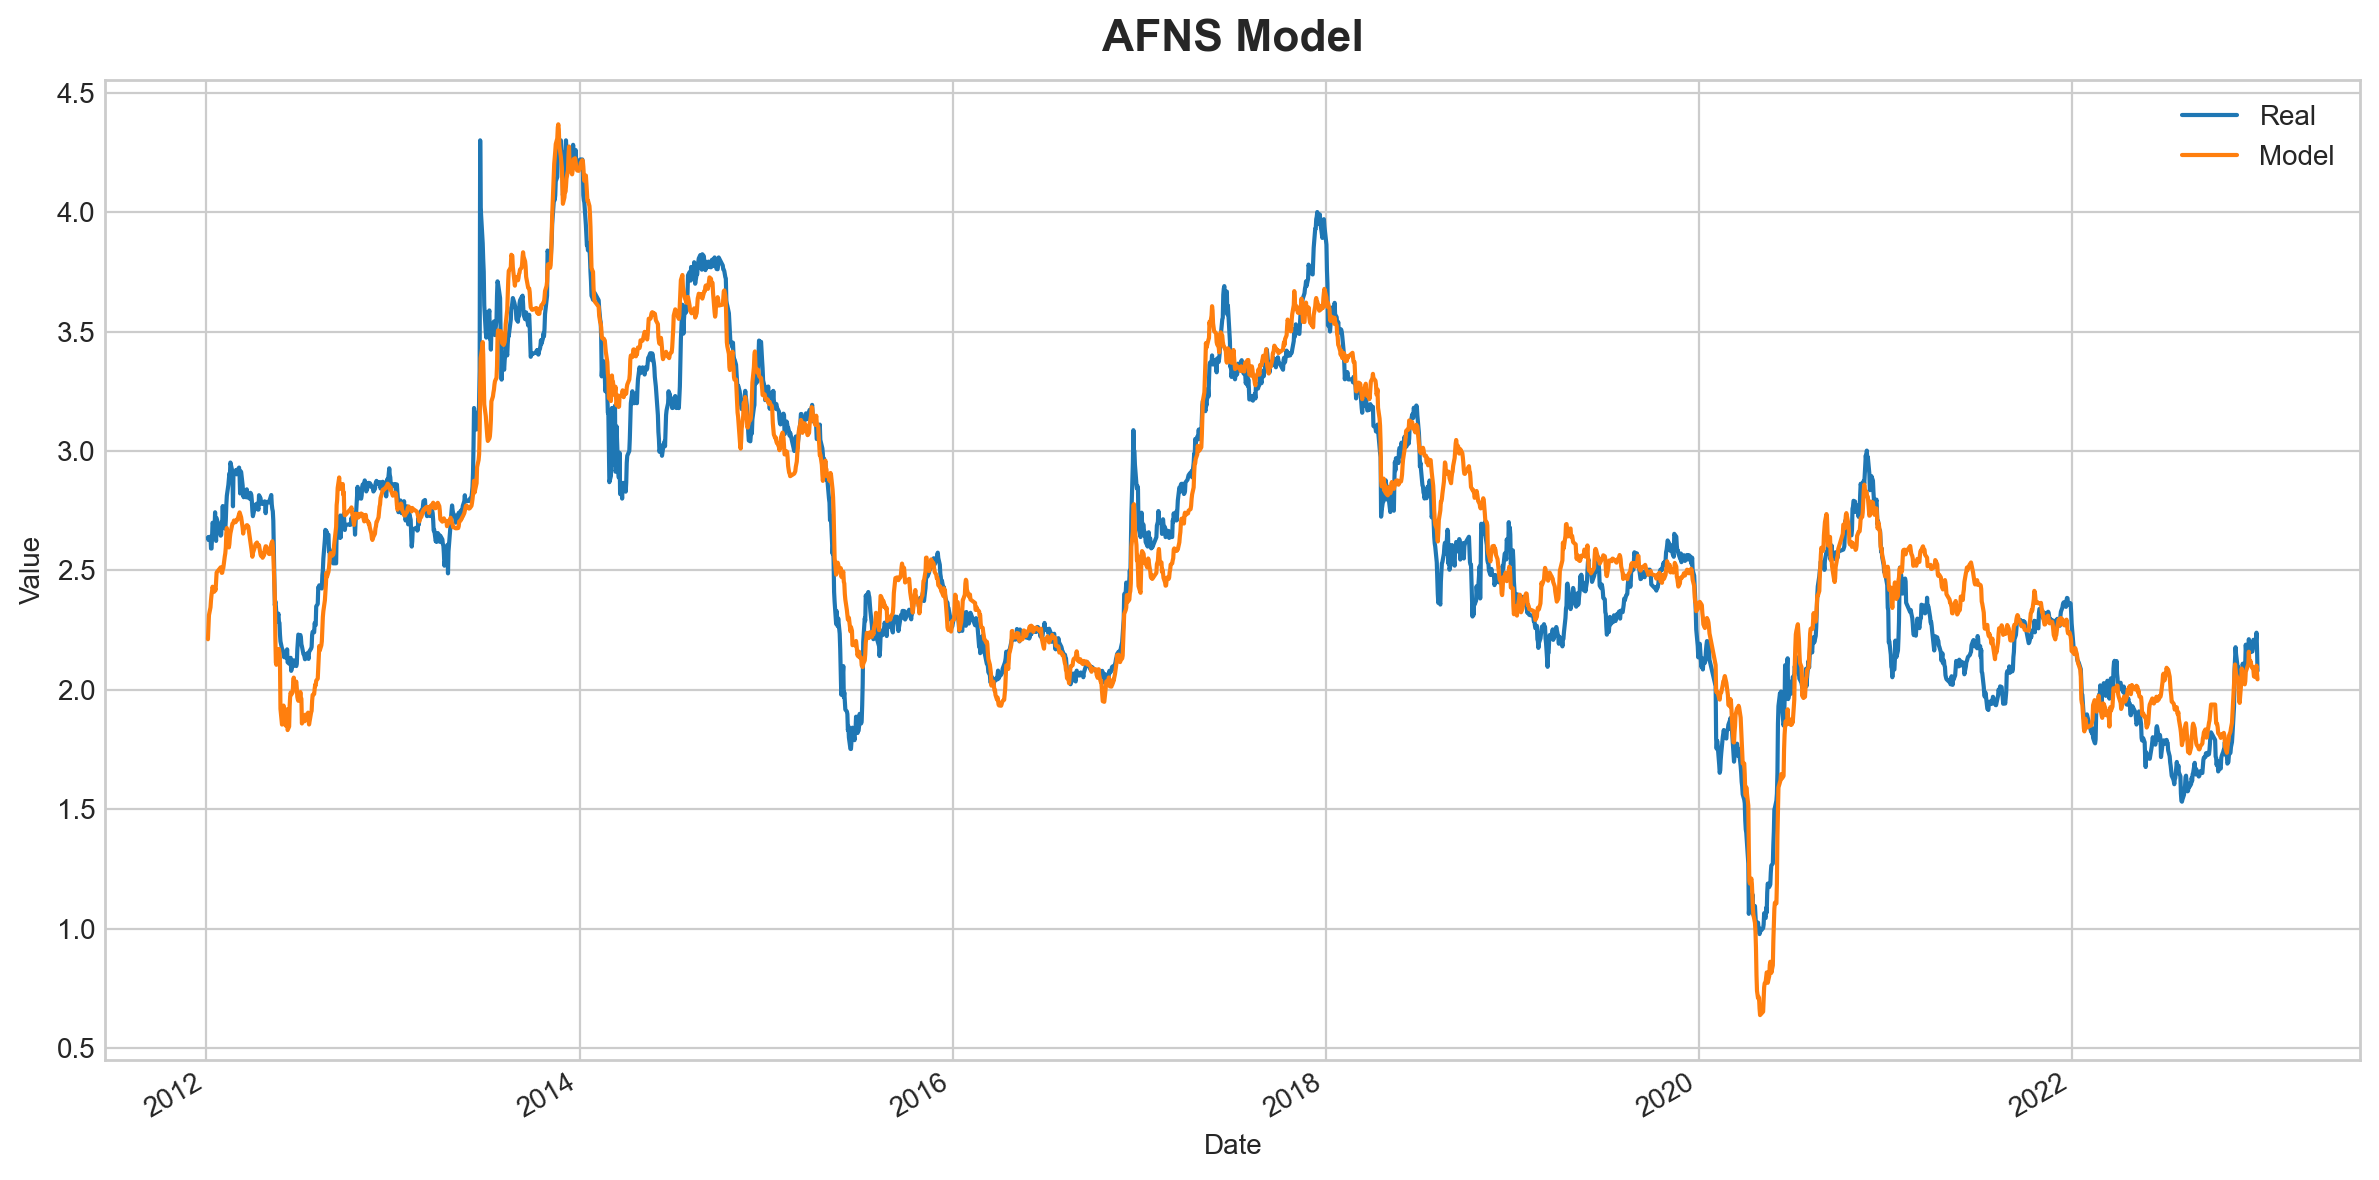

In [9]:
# 模型值与真实值对比
fig, ax = plt.subplots(figsize=(12, 6))
tenor="6M"
ax.plot(real_ytm_df['Date'], real_ytm_df[tenor], label="Real")
ax.plot(model_ytm_df['Date'], model_ytm_df[tenor], label="Model")


ax.set_title("AFNS Model")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
fig.autofmt_xdate()
plt.tight_layout()
plt.legend(loc=1)

In [10]:
# 计算MAPE:平均绝对百分比误差
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [11]:
# 因子预测分析： 计算MAE(平均绝对误差), MAPE(平均绝对百分比误差)， RMSE(均方根误差)的值
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [12]:
# 均方根误差
import math
def rmse(y_true, y_pred):
    MSE = np.square(np.subtract(y_true,y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    return RMSE

In [13]:
columns_list = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']
mae_list = []
mape_list = []
rmse_list = []
for temp_column in columns_list:
    #print(temp_column)
    temp_mae = mae(real_ytm_df[temp_column], model_ytm_df[temp_column])
    temp_mape = mape(real_ytm_df[temp_column], model_ytm_df[temp_column])
    temp_rmse =  rmse(real_ytm_df[temp_column], model_ytm_df[temp_column]) * 100
    mae_list.append(temp_mae)
    mape_list.append(temp_mape)
    rmse_list.append(temp_rmse)

error_df = pd.DataFrame()
error_df['Tenor'] = columns_list
error_df['MAE'] = mae_list
error_df['MAPE'] = mape_list
error_df['RMSE'] = rmse_list
error_df

,Tenor,MAE,MAPE,RMSE
0,6M,0.134534,5.626044,17.352907
1,1Y,0.095828,3.889602,13.061343
2,2Y,0.045916,1.696011,6.535254
3,3Y,0.021859,0.750308,2.909957
4,4Y,0.016453,0.571091,1.952064
5,5Y,0.021280,0.697699,2.741974
6,6Y,0.013814,0.438181,1.822978
7,7Y,0.034015,1.076898,4.280576
8,8Y,0.026670,0.815577,3.324161
9,9Y,0.058834,1.825148,6.653787


## 可预测性

In [14]:
level_adf_result = adfuller(factor_df['Level'])

print(f'ADF Statistic: {level_adf_result[0]}')
print(f'p-value: {level_adf_result[1]}')

ADF Statistic: -0.5030126563373339
p-value: 0.8914272548158708


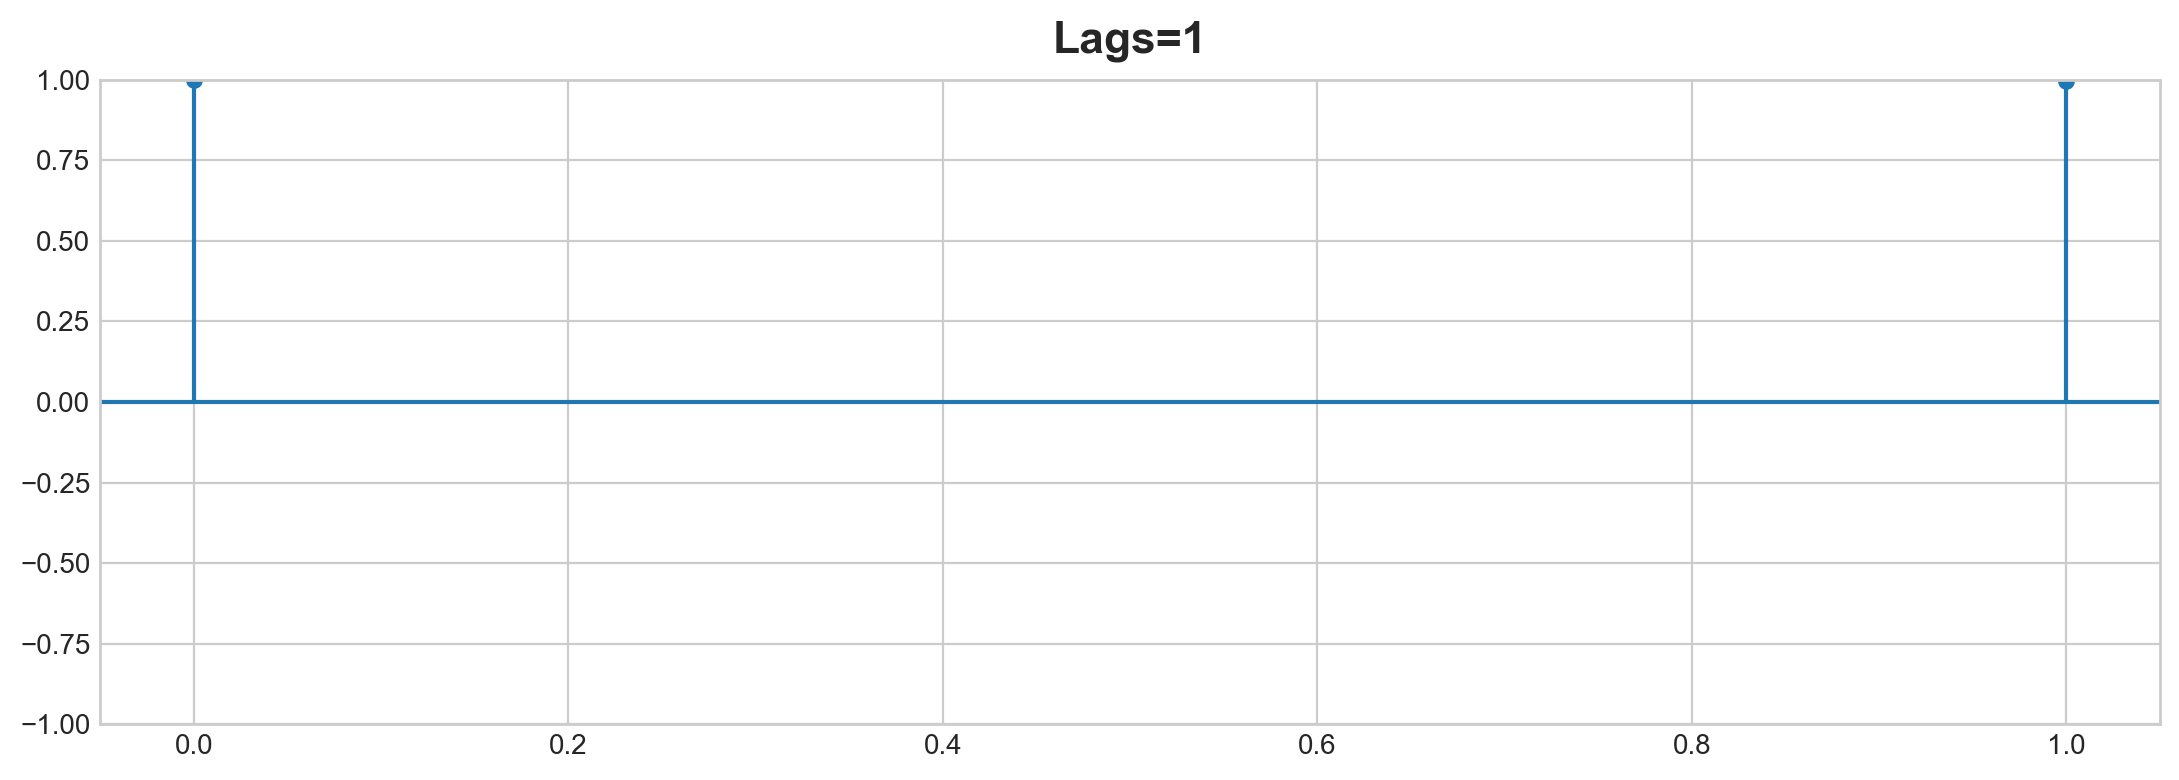

In [15]:
plot_acf(factor_df['Level'], lags=1, title="Lags=1")

plt.tight_layout()

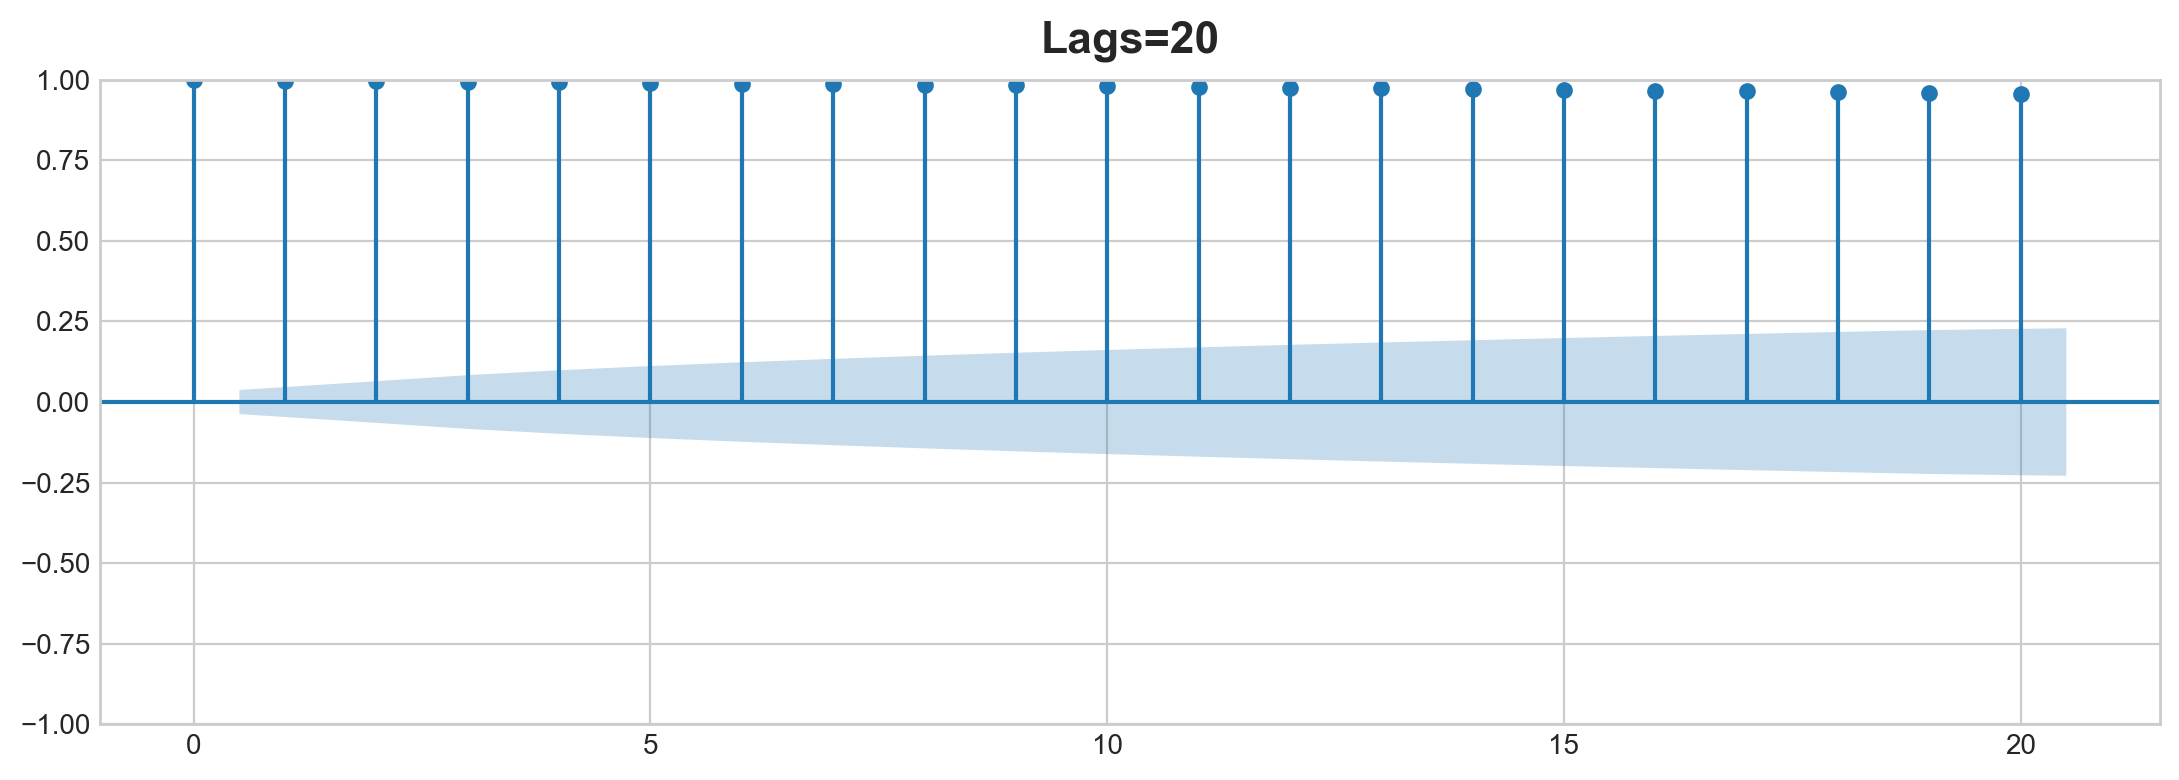

In [16]:
plot_acf(factor_df['Level'], lags=20, title="Lags=20")

plt.tight_layout()

In [17]:
level_diff = np.diff(factor_df['Level'], n=1)

level_diff_adf_result = adfuller(level_diff)

print(f'ADF Statistic: {level_diff_adf_result[0]}')
print(f'p-value: {level_diff_adf_result[1]}')

ADF Statistic: -12.538352300601352
p-value: 2.344366873765816e-23


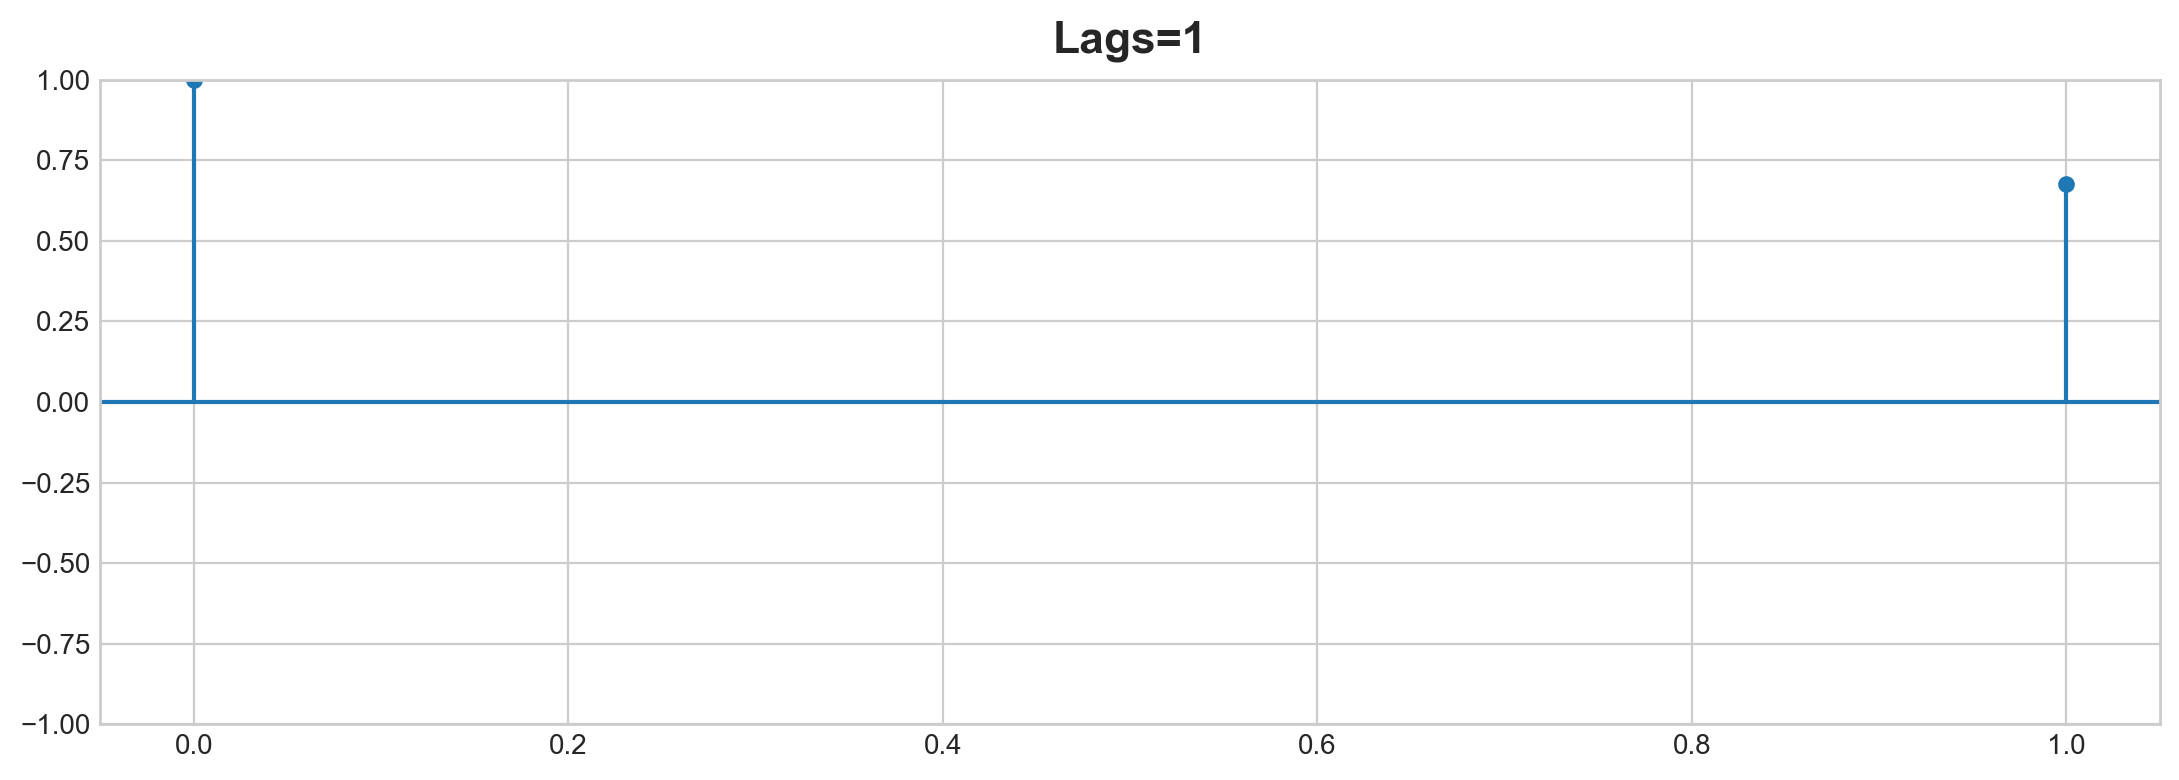

In [18]:
plot_acf(level_diff, lags=1, title="Lags=1")

plt.tight_layout()

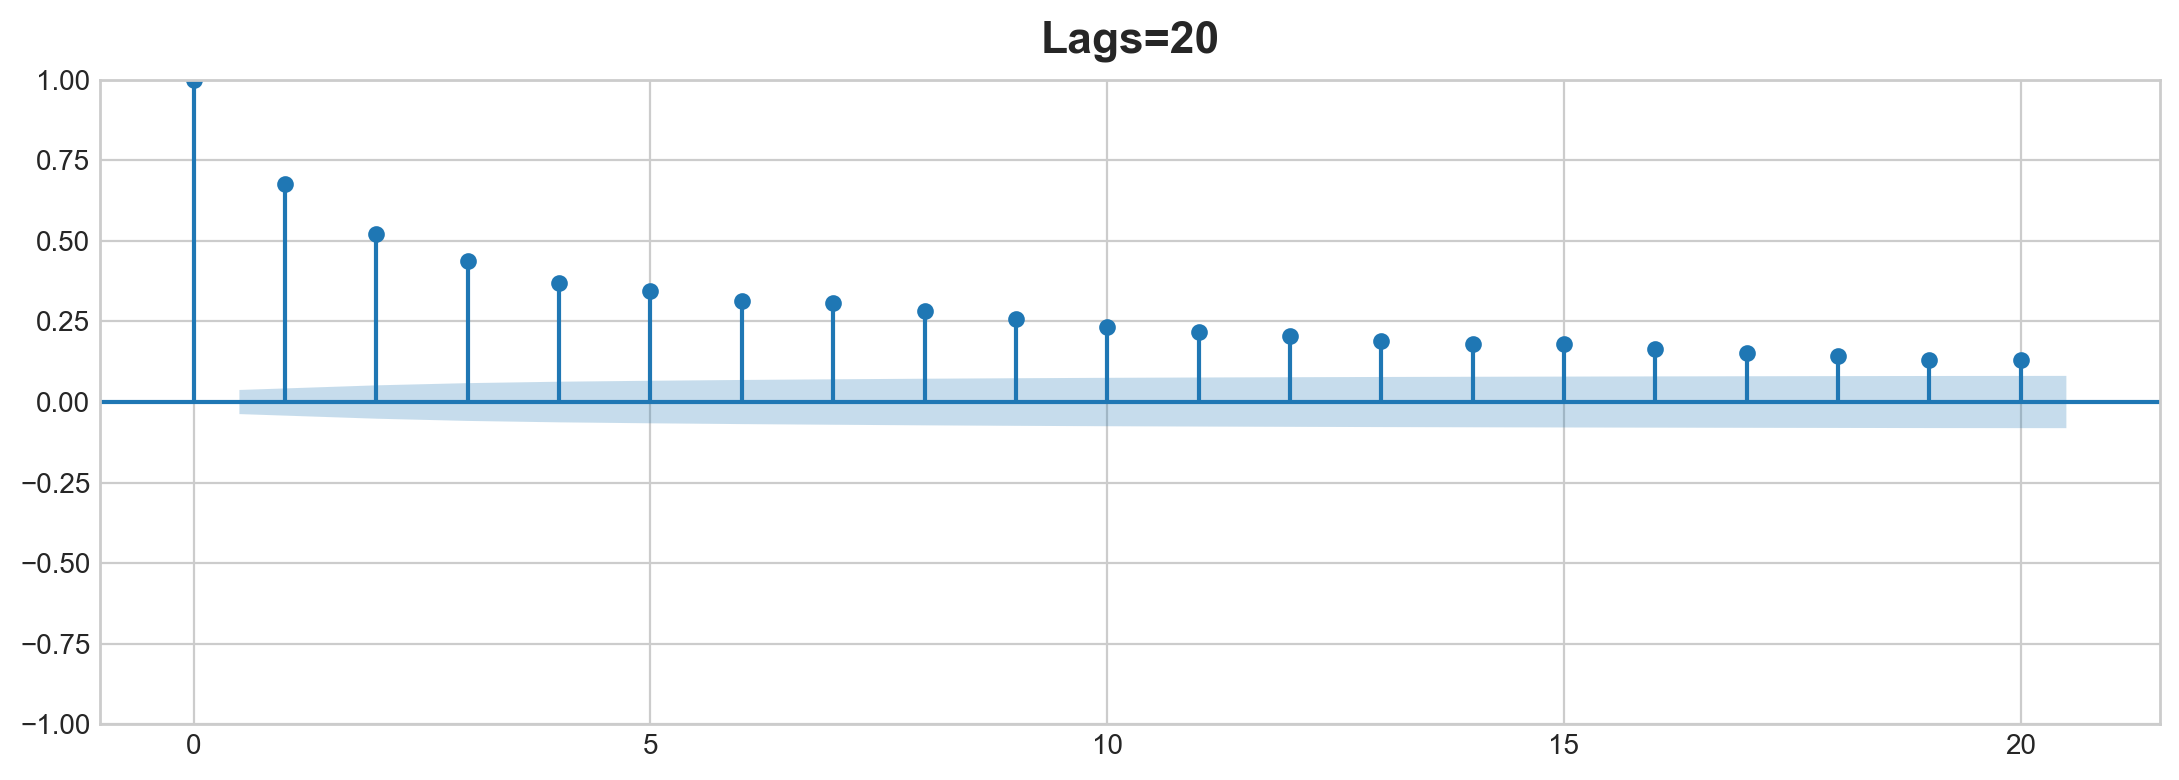

In [19]:
plot_acf(level_diff, lags=20, title="Lags=20")

plt.tight_layout()

In [20]:
slope_adf_result = adfuller(factor_df['Slope'])

print(f'ADF Statistic: {slope_adf_result[0]}')
print(f'p-value: {slope_adf_result[1]}')

ADF Statistic: -3.7068330248199555
p-value: 0.004018061681590629


In [21]:
curvature_adf_result = adfuller(factor_df['Curvature'])

print(f'ADF Statistic: {curvature_adf_result[0]}')
print(f'p-value: {curvature_adf_result[1]}')

ADF Statistic: -4.145326224812559
p-value: 0.0008142869403961417


## 模型值与真实值的误差

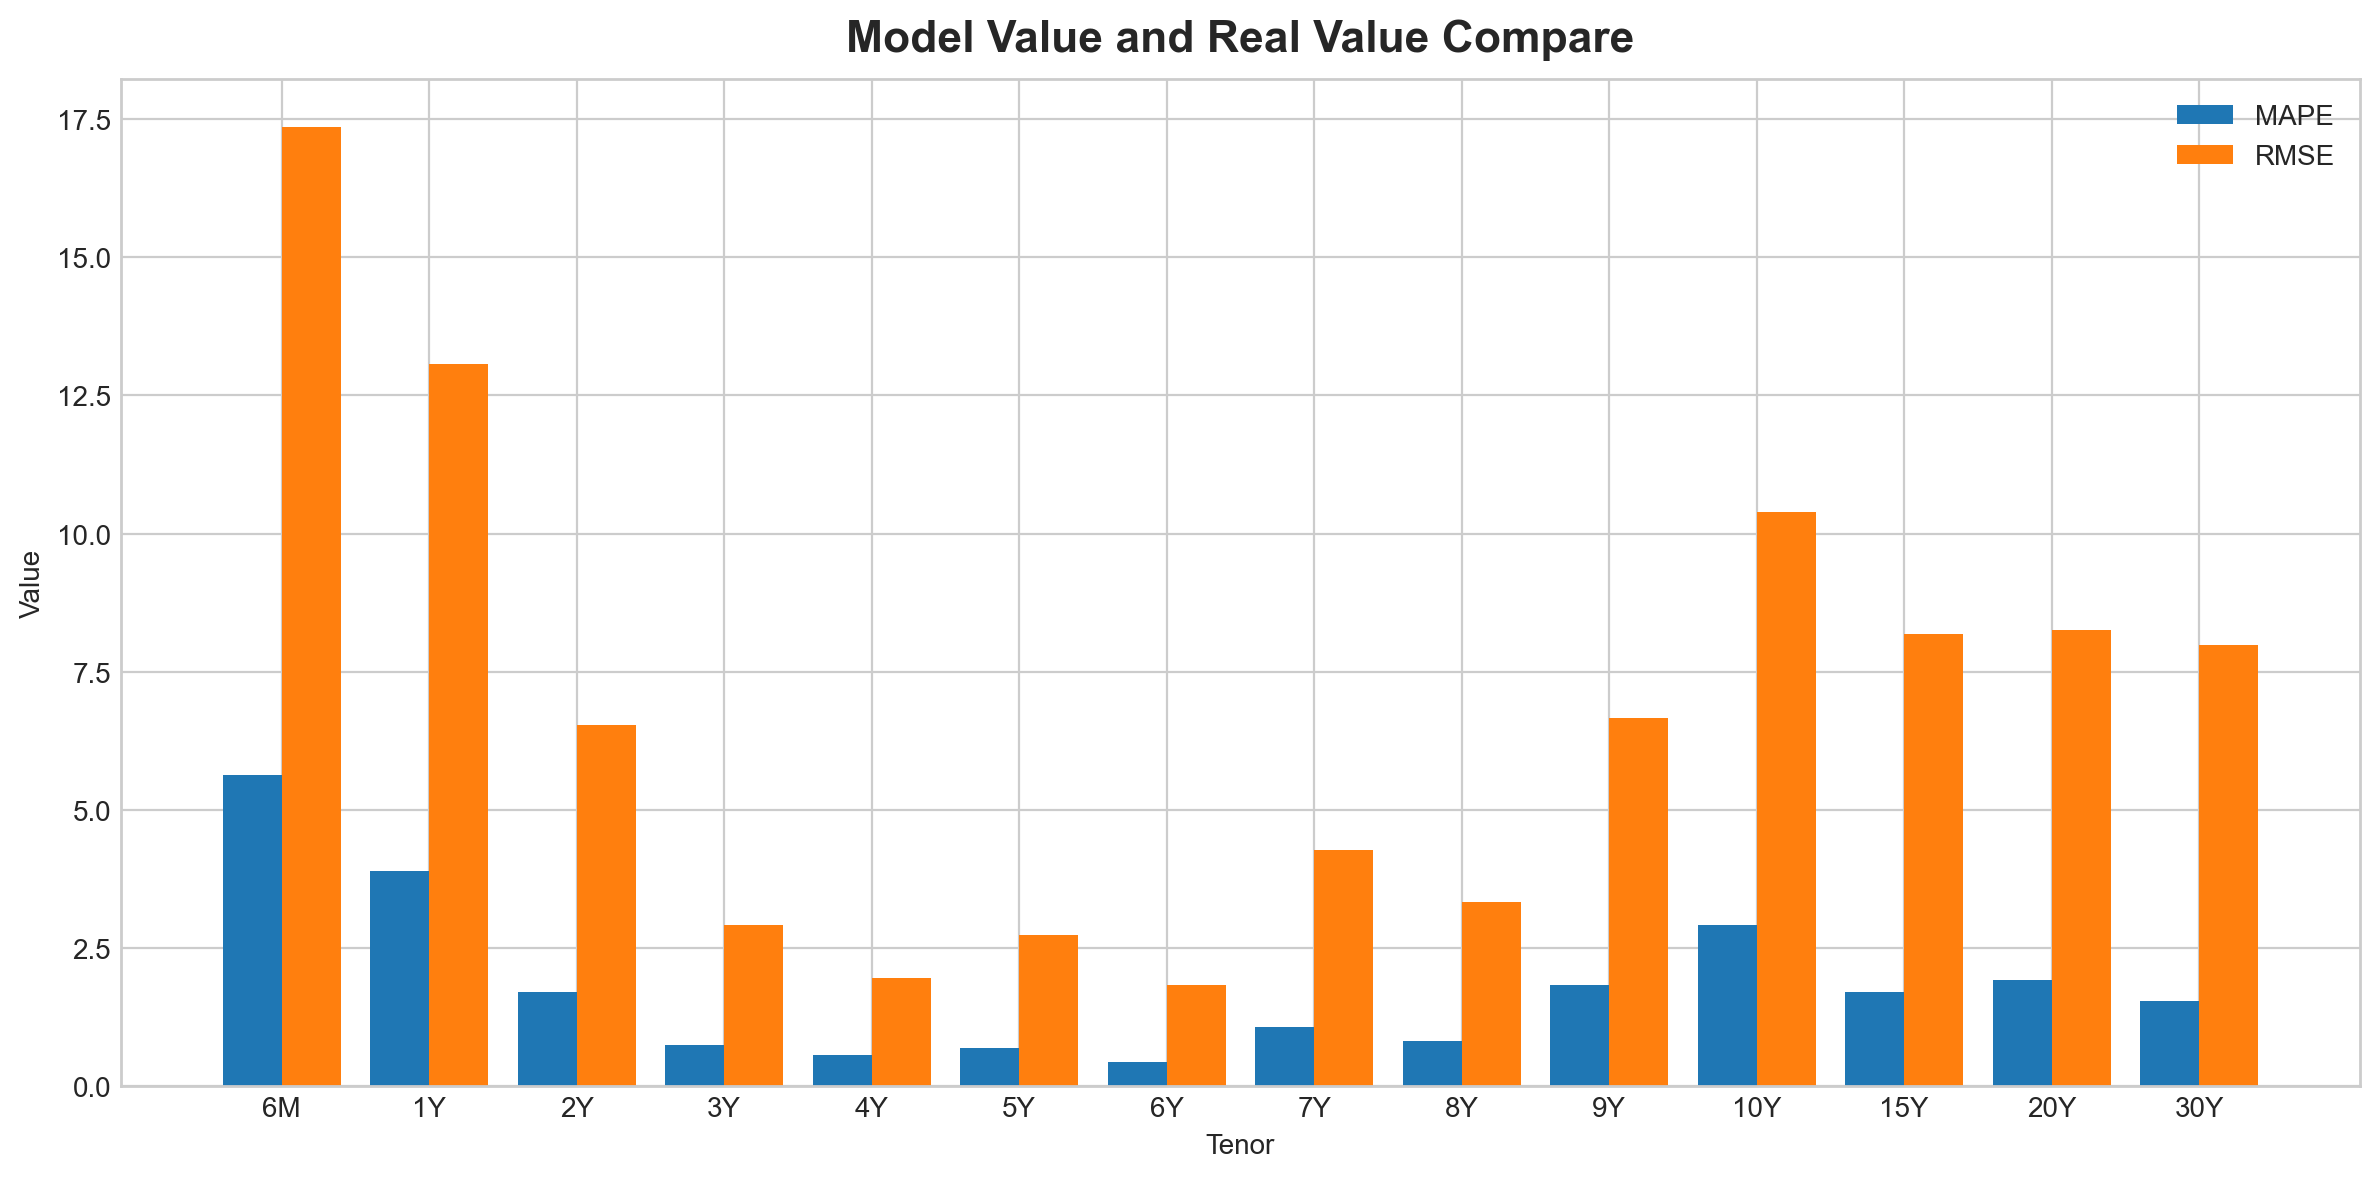

In [22]:
# 可视化误差
fig, ax = plt.subplots(figsize=(12, 6))

totalWidth=0.8 # 一组柱状体的宽度
labelNums=2 # 一组有两种类别
barWidth=totalWidth/labelNums # 单个柱体的宽度
seriesNums=error_df.shape[0] # 一共有多少组

ax.bar([x for x in range(seriesNums)], error_df['MAPE'], label="MAPE", width=barWidth)
ax.bar([x+barWidth for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)

plt.xticks([x+barWidth/2*(labelNums-1) for x in range(seriesNums)], error_df['Tenor'])
plt.xlabel("Tenor")
plt.ylabel("Value")
plt.title("Model Value and Real Value Compare")
plt.legend()
plt.show()

In [23]:
# 保存模型值与真实值的误差
error_df.to_csv('./data/AFNS_Compare.csv', index=False, encoding="utf-8-sig")

In [24]:
error_df

,Tenor,MAE,MAPE,RMSE
0,6M,0.134534,5.626044,17.352907
1,1Y,0.095828,3.889602,13.061343
2,2Y,0.045916,1.696011,6.535254
3,3Y,0.021859,0.750308,2.909957
4,4Y,0.016453,0.571091,1.952064
5,5Y,0.021280,0.697699,2.741974
6,6Y,0.013814,0.438181,1.822978
7,7Y,0.034015,1.076898,4.280576
8,8Y,0.026670,0.815577,3.324161
9,9Y,0.058834,1.825148,6.653787


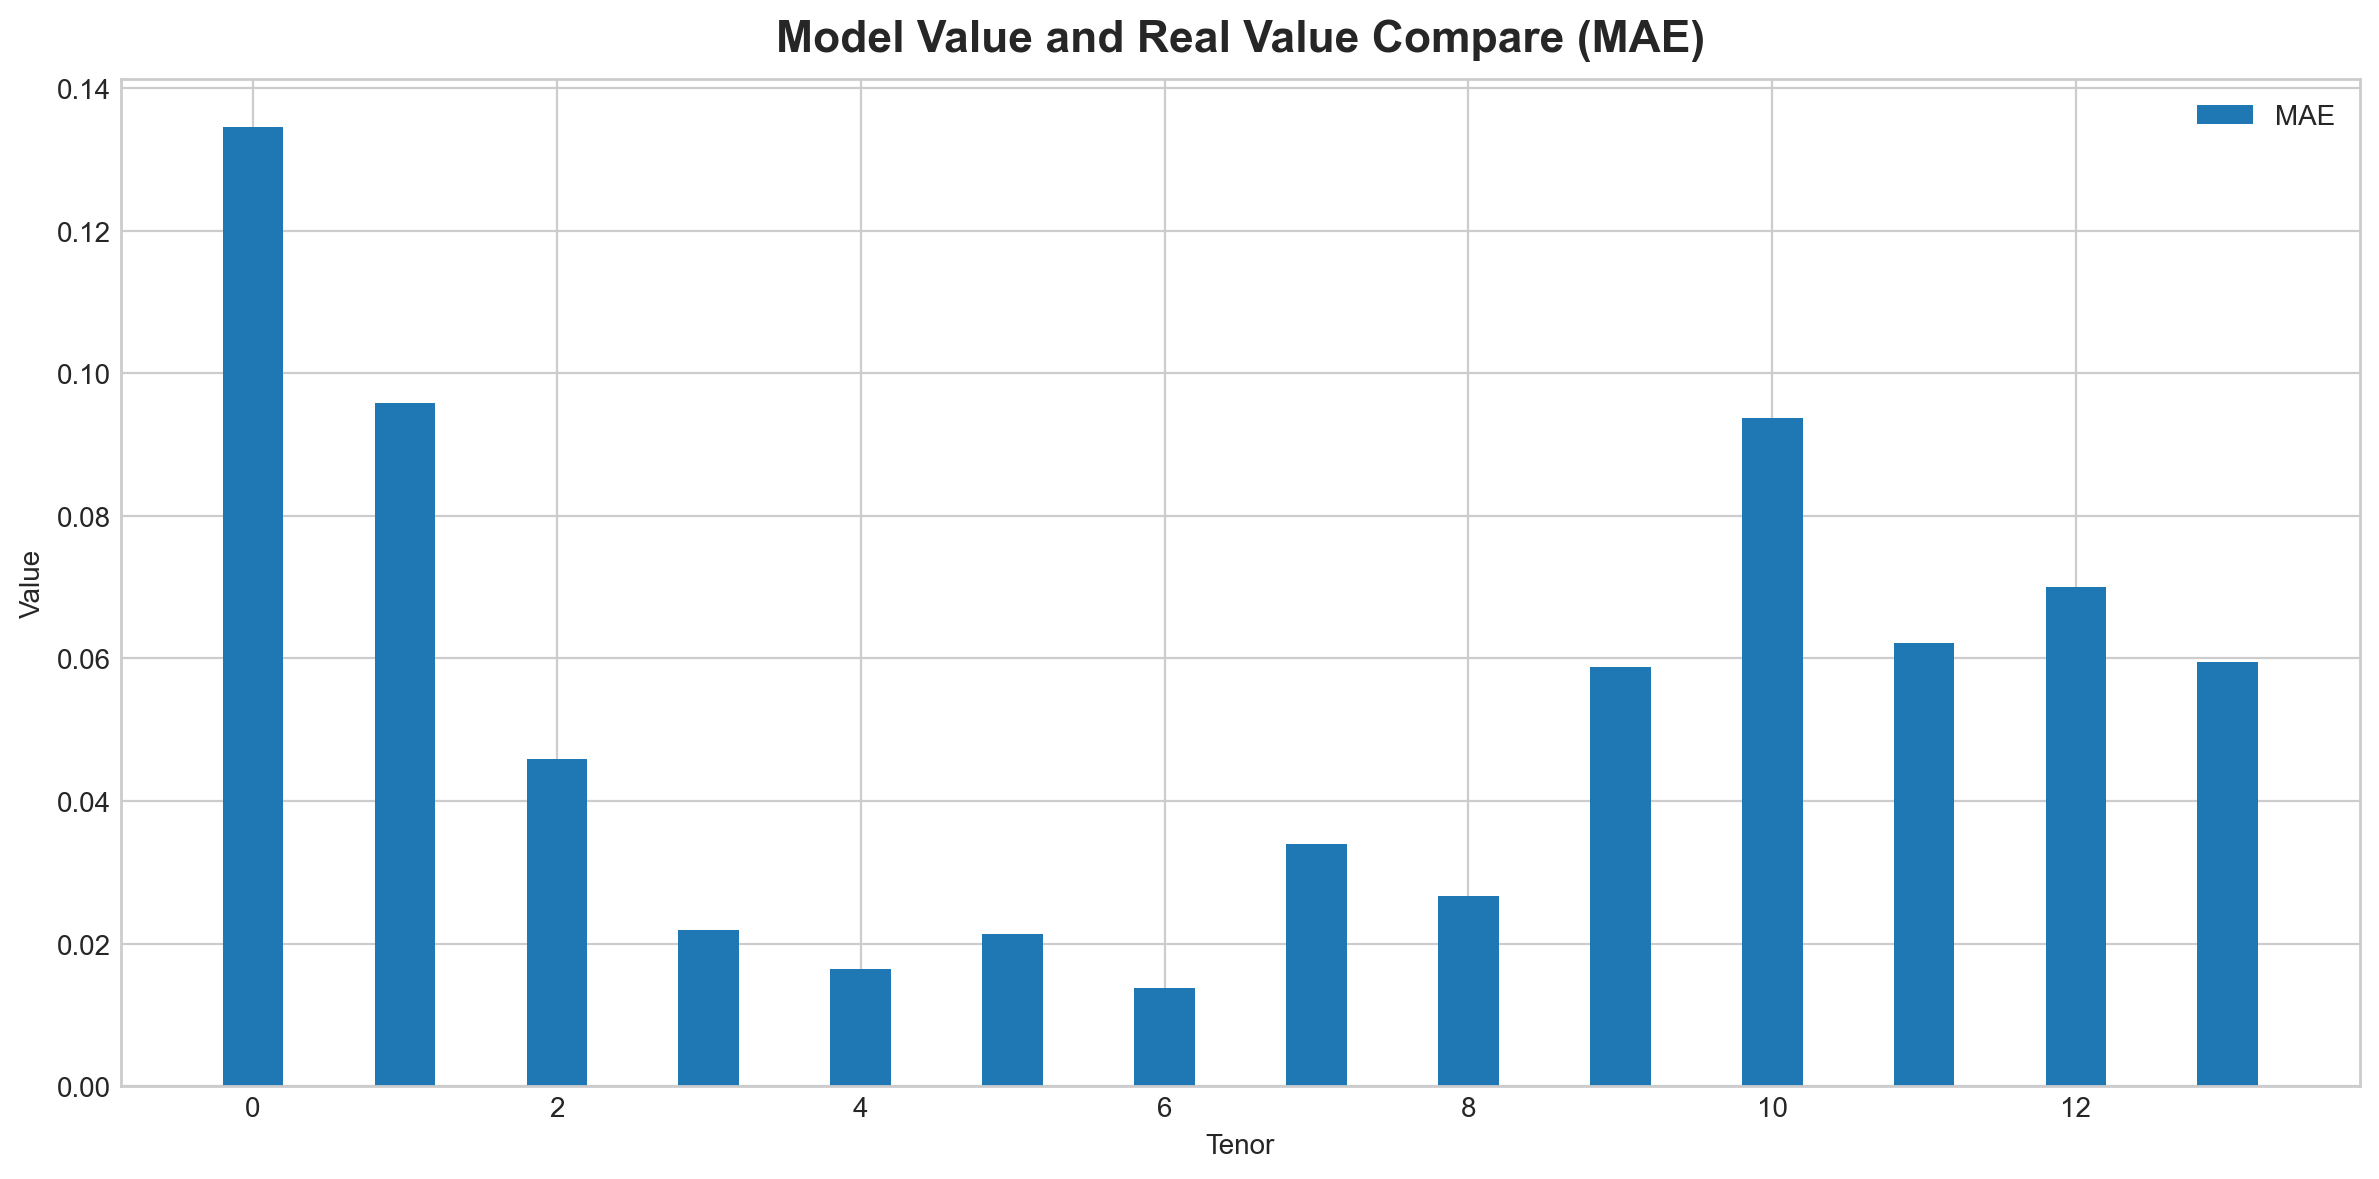

In [25]:
# 可视化误差
fig, ax = plt.subplots(figsize=(12, 6))

totalWidth=0.8 # 一组柱状体的宽度
labelNums=2 # 一组有两种类别
barWidth=totalWidth/labelNums # 单个柱体的宽度
seriesNums=error_df.shape[0] # 一共有多少组

ax.bar([x for x in range(seriesNums)], error_df['MAE'], label="MAE", width=barWidth)
#ax.bar([x+barWidth for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)

#plt.xticks([x+barWidth/2*(labelNums-1) for x in range(seriesNums)], error_df['Tenor'])
plt.xlabel("Tenor")
plt.ylabel("Value")
plt.title("Model Value and Real Value Compare (MAE)")
plt.legend()
plt.show()

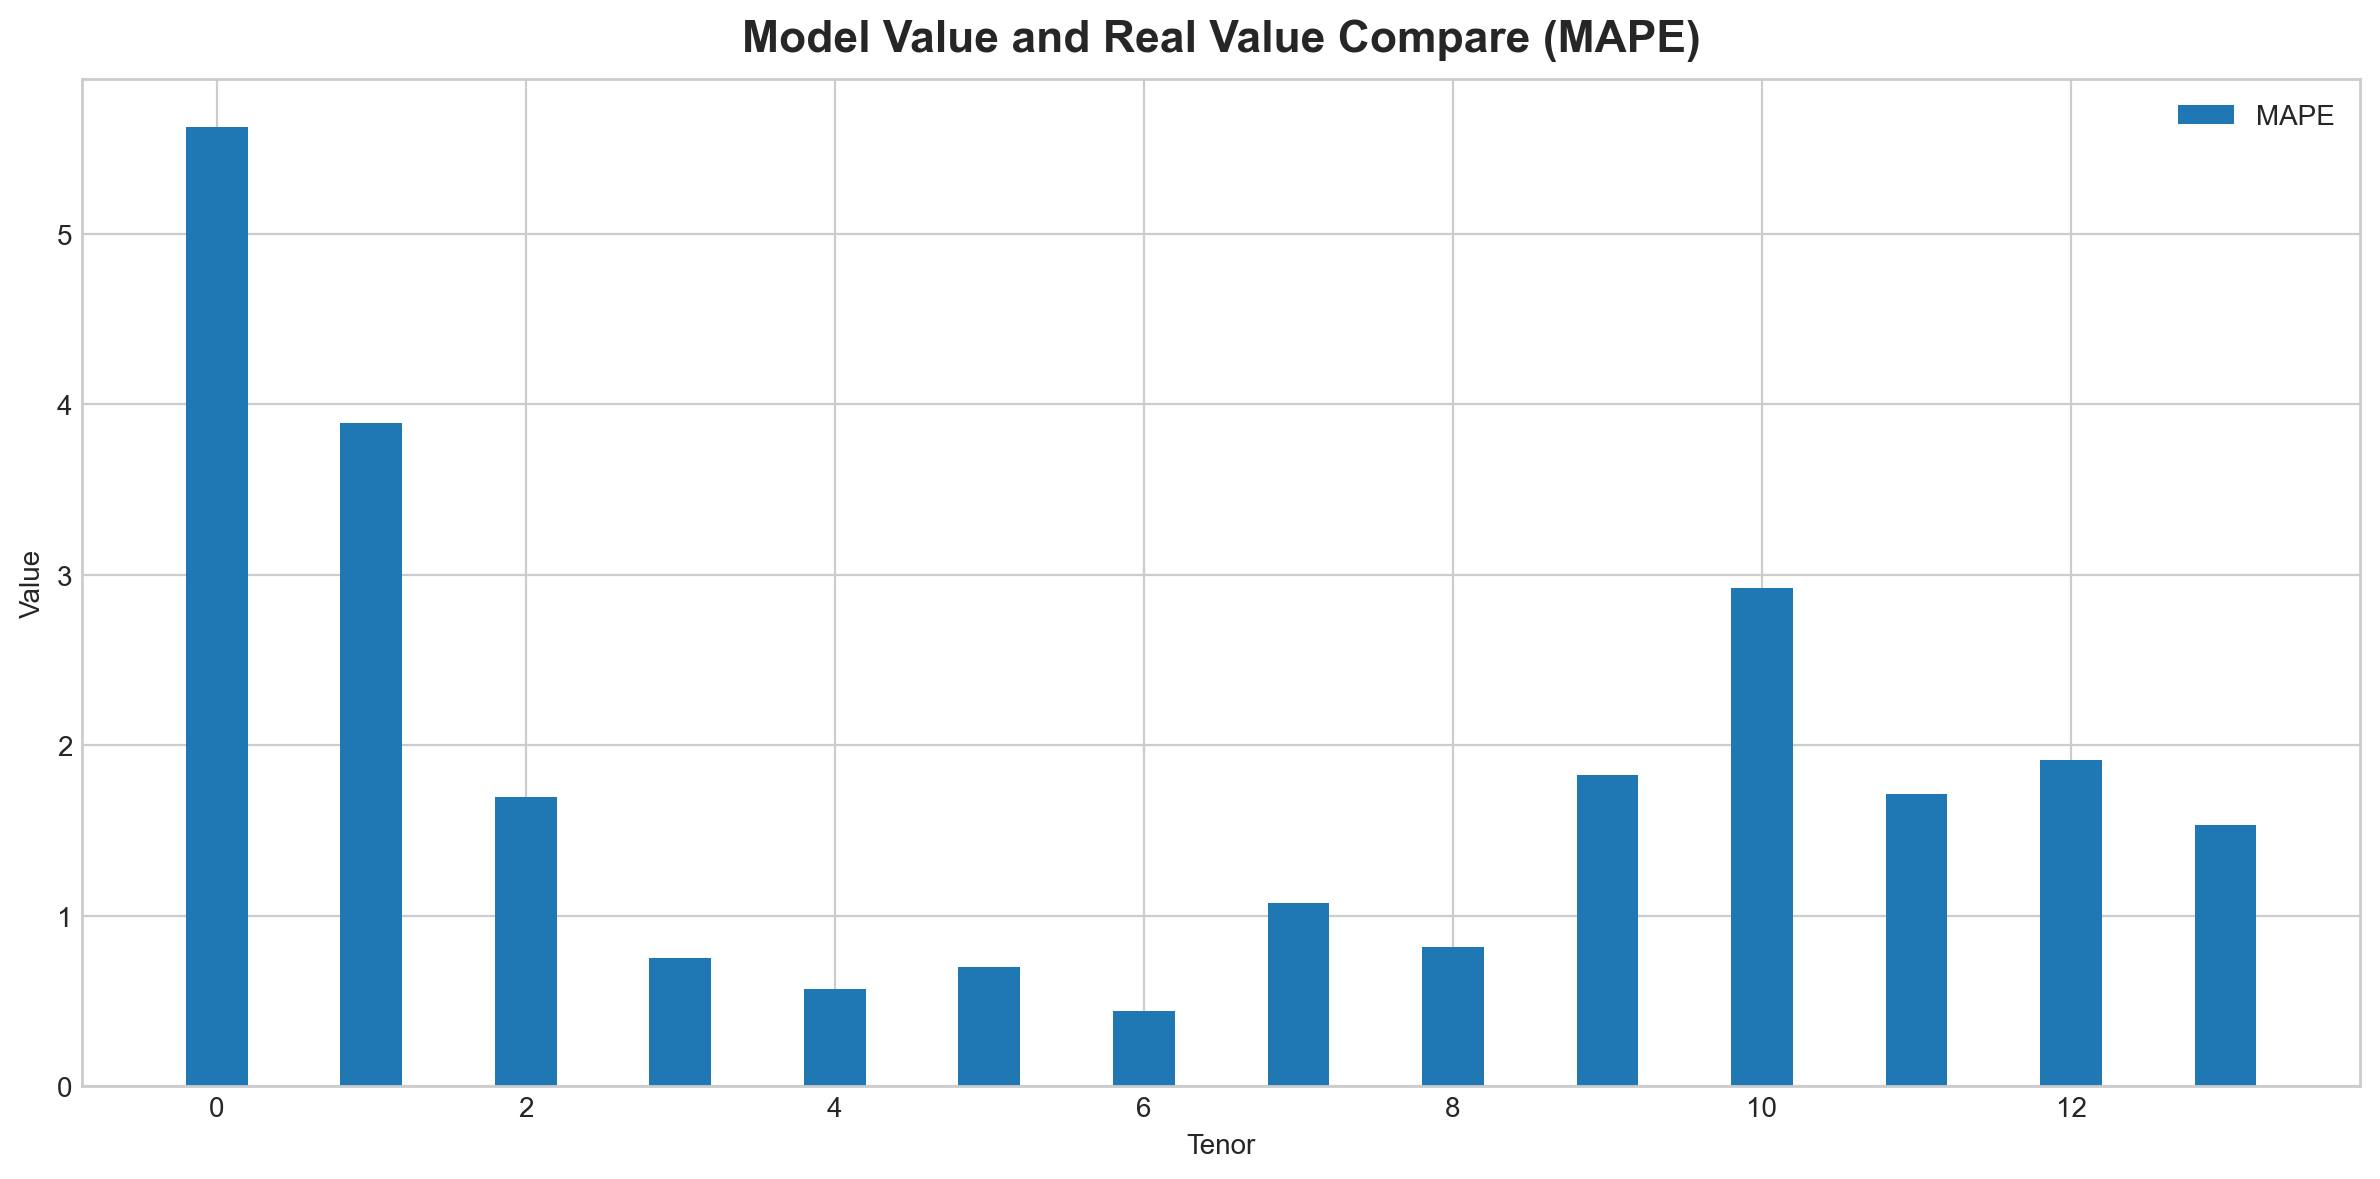

In [26]:
# 可视化误差
fig, ax = plt.subplots(figsize=(12, 6))

totalWidth=0.8 # 一组柱状体的宽度
labelNums=2 # 一组有两种类别
barWidth=totalWidth/labelNums # 单个柱体的宽度
seriesNums=error_df.shape[0] # 一共有多少组

ax.bar([x for x in range(seriesNums)], error_df['MAPE'], label="MAPE", width=barWidth)
#ax.bar([x+barWidth for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)

#plt.xticks([x+barWidth/2*(labelNums-1) for x in range(seriesNums)], error_df['Tenor'])
plt.xlabel("Tenor")
plt.ylabel("Value")
plt.title("Model Value and Real Value Compare (MAPE)")
plt.legend()
plt.show()

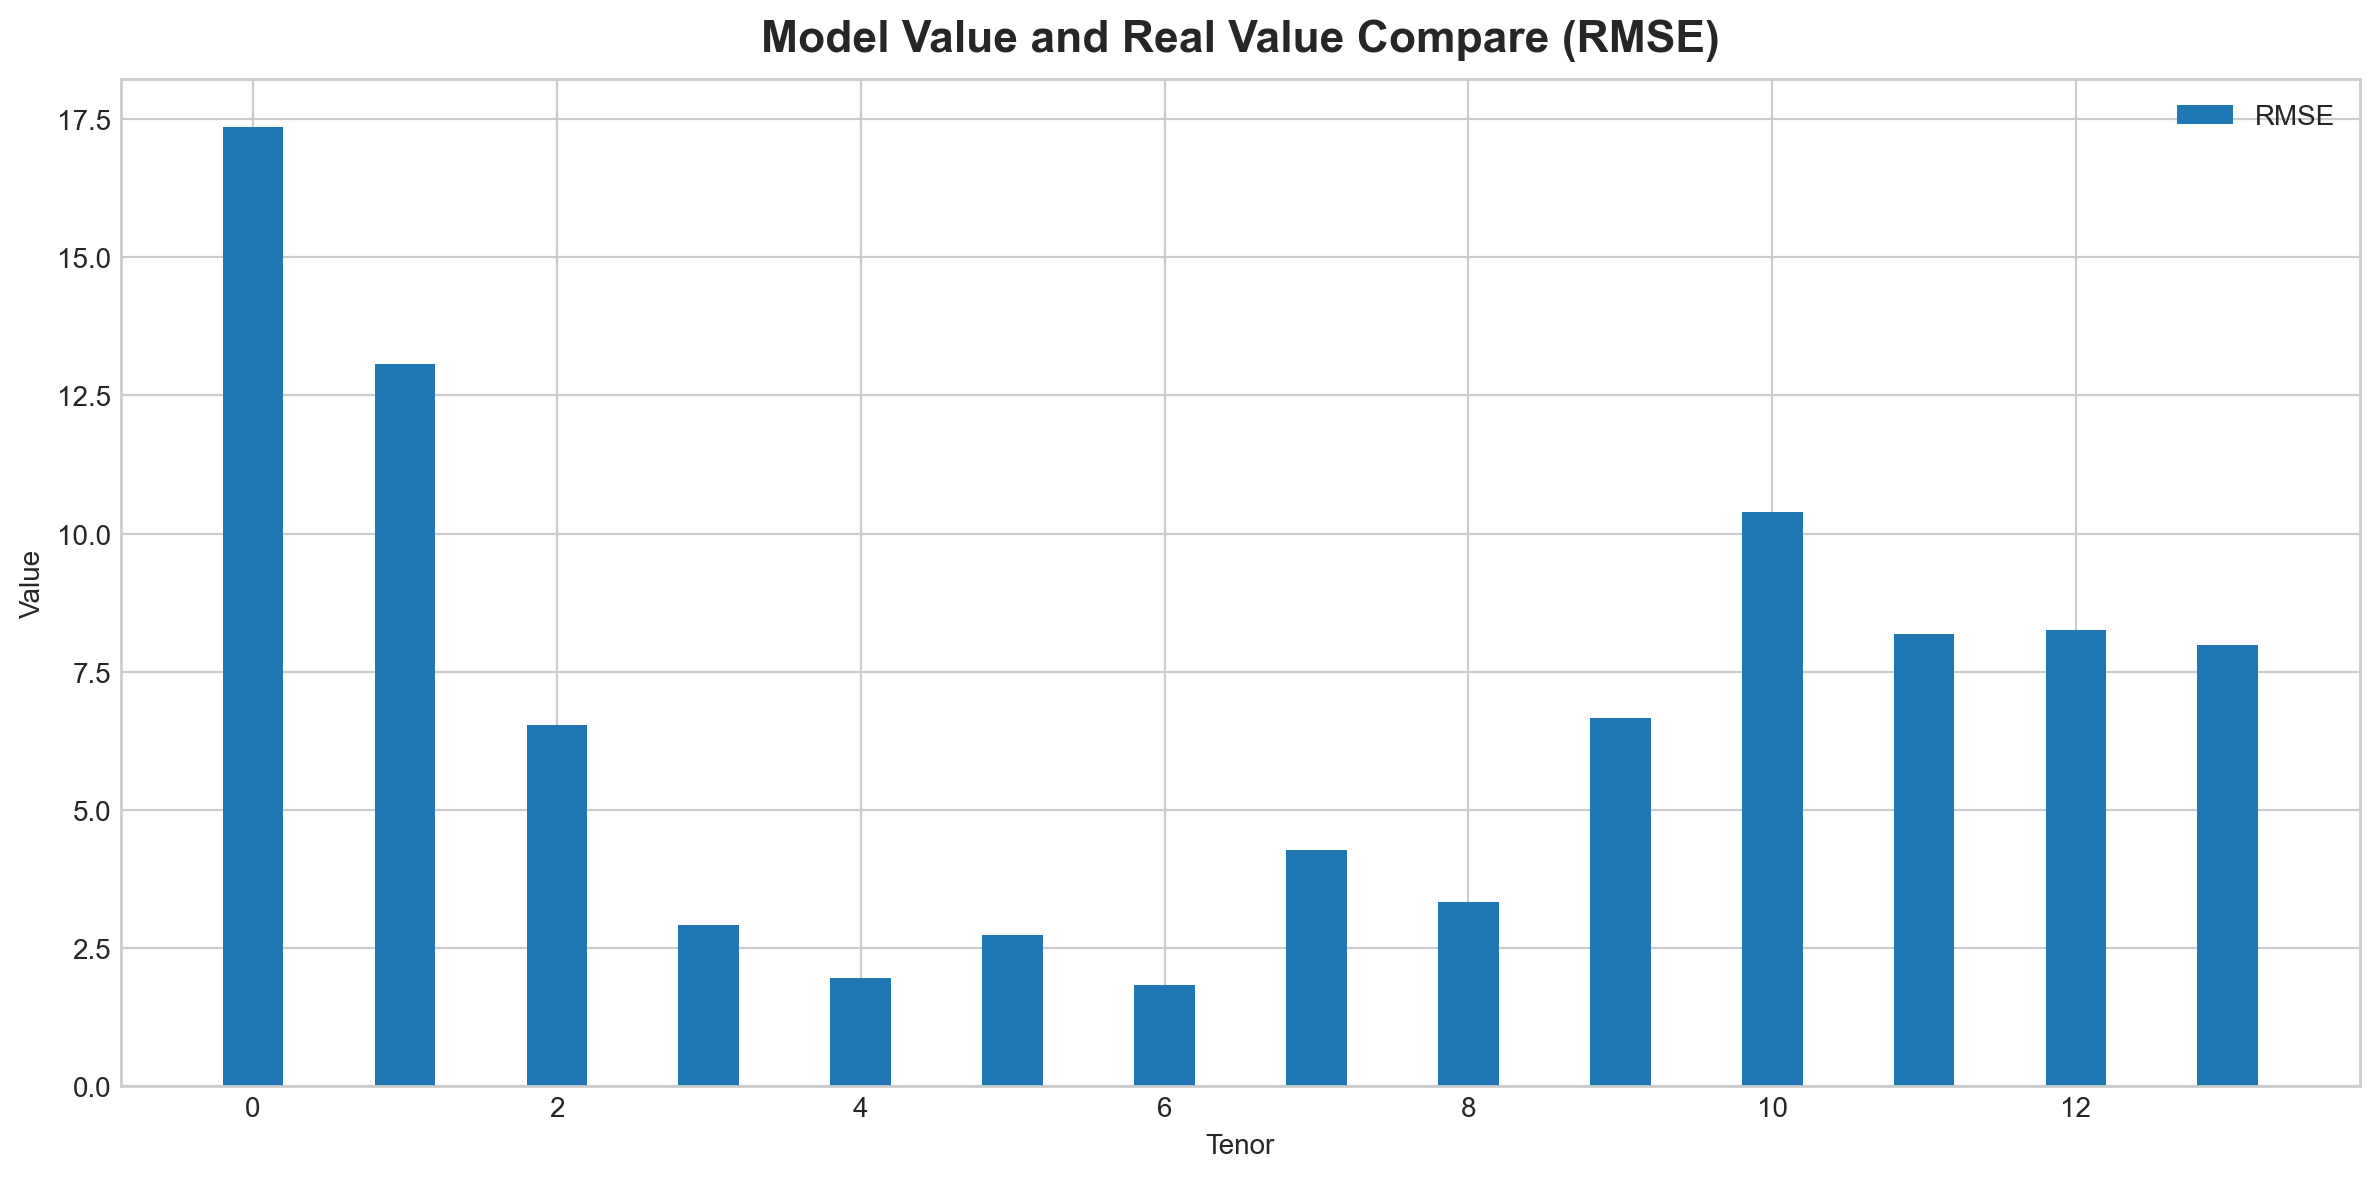

In [27]:
# 可视化误差
fig, ax = plt.subplots(figsize=(12, 6))

totalWidth=0.8 # 一组柱状体的宽度
labelNums=2 # 一组有两种类别
barWidth=totalWidth/labelNums # 单个柱体的宽度
seriesNums=error_df.shape[0] # 一共有多少组

ax.bar([x for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)
#ax.bar([x+barWidth for x in range(seriesNums)], error_df['RMSE'], label="RMSE", width=barWidth)

#plt.xticks([x+barWidth/2*(labelNums-1) for x in range(seriesNums)], error_df['Tenor'])
plt.xlabel("Tenor")
plt.ylabel("Value")
plt.title("Model Value and Real Value Compare (RMSE)")
plt.legend()
plt.show()